# Data Mining Coursework. Mashrooms

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from pca import pca
import logistic_regression as logit
import neural_network as nn
import decision_tree as dt

import sklearn.linear_model

## Download data

Download data from the web

In [2]:
file_path = "http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

df = pd.read_table(file_path, sep=",", header=None)
df.columns = ["edible", "cap_shape", "cap_surface", "cap_color", "bruises", "odor", "gill_attachment", "gill_spacing",
              "gill_size", "gill_color", "stalk_shape", "stalk_root", "stalk_surface_above_ring", 
              "stalk_surface_below_ring", "stalk_color_above_ring", "stalk_color_below_ring", "veil_type", 
              "veil_color", "ring_number", "ring_type", "spore_print_color", "population", "habitat"]
df = df.astype('category')
del(file_path)
df.head()

,edible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Exploratory analysis

### Frequencies for all variables

In [3]:
df['counter'] = 1
most_frequent_level = {}


for col in df.columns[:-1]:
    frequency          = pd.DataFrame(df.groupby(col)['counter'].describe()['count'])
    frequency['share'] = round(frequency['count'] / sum(frequency['count']) * 100,2)
    frequency          = frequency.sort_values(by='count', ascending=False)
    
    most_frequent_level[col] = frequency.index[0]
    
    print(frequency, '\n')
del(col, frequency)

         count  share
edible               
e       4208.0   51.8
p       3916.0   48.2 

            count  share
cap_shape               
x          3656.0  45.00
f          3152.0  38.80
k           828.0  10.19
b           452.0   5.56
s            32.0   0.39
c             4.0   0.05 

              count  share
cap_surface               
y            3244.0  39.93
s            2556.0  31.46
f            2320.0  28.56
g               4.0   0.05 

            count  share
cap_color               
n          2284.0  28.11
g          1840.0  22.65
e          1500.0  18.46
y          1072.0  13.20
w          1040.0  12.80
b           168.0   2.07
p           144.0   1.77
c            44.0   0.54
r            16.0   0.20
u            16.0   0.20 

          count  share
bruises               
f        4748.0  58.44
t        3376.0  41.56 

       count  share
odor               
n     3528.0  43.43
f     2160.0  26.59
s      576.0   7.09
y      576.0   7.09
a      400.0   4.92
l      4

- Approximately half of mashrooms in the datset are edible, others are poisonous  
- Only variable **stalk_root** has missing variables  
- Variable **veil_type** has only one level, it can be deleted   
- Many variables have levels that are represented by only few examples. Such variables likely have small predictive power  

30% of variables have missing value of stalk_root. As a result it is not reasonable to simply delete all observations with missing data. Our approach of dealing with the problem will be to try three methods, evaluate their impact on accuracy of prediction and choose the most efficient one.

Three approaches:  

- delete variable **stalk_root**  
- randomly substitute the missing values using the frequencies of non-missing values of **stalk_root**  
- predict missing values of **stalk_root**  

The third method is problematic because **stalk_root** has two minority classes with frequencies 3% and 10%. Thus predicting **stalk_root** is complicated by the class imbalance problem.

To predict values of **edible** we will use three clasification algorithms - logistic regression, neural network and decision tree.

In [4]:
# remove unnecessary variables
df = df.drop(['veil_type', 'counter'], axis=1)

# remove veil_type from the dictionary most_frequent_level
most_frequent_level.pop("veil_type")

'p'

### Intersection of variable **edible** with other variables

In [5]:
df['counter'] = 1

for col in df.columns[1:-1]:
    group_2 = df.groupby(['edible', col])
    group_2 = pd.DataFrame(group_2.sum())
    group_2['share'] = round(group_2['counter'] / np.nansum(group_2['counter'], ) * 100,2)
    
    print(group_2, '\n')
del(col, group_2)
df = df.drop(['counter'], axis=1)

                  counter  share
edible cap_shape                
e      b            404.0   4.97
       c              NaN    NaN
       f           1596.0  19.65
       k            228.0   2.81
       s             32.0   0.39
       x           1948.0  23.98
p      b             48.0   0.59
       c              4.0   0.05
       f           1556.0  19.15
       k            600.0   7.39
       s              NaN    NaN
       x           1708.0  21.02 

                    counter  share
edible cap_surface                
e      f             1560.0  19.20
       g                NaN    NaN
       s             1144.0  14.08
       y             1504.0  18.51
p      f              760.0   9.35
       g                4.0   0.05
       s             1412.0  17.38
       y             1740.0  21.42 

                  counter  share
edible cap_color                
e      b             48.0   0.59
       c             32.0   0.39
       e            624.0   7.68
       g           

                counter  share
edible habitat                
e      d         1880.0  23.14
       g         1408.0  17.33
       l          240.0   2.95
       m          256.0   3.15
       p          136.0   1.67
       u           96.0   1.18
       w          192.0   2.36
p      d         1268.0  15.61
       g          740.0   9.11
       l          592.0   7.29
       m           36.0   0.44
       p         1008.0  12.41
       u          272.0   3.35
       w            NaN    NaN 



While some varibles have levels that are strictly specific to either edible or poisonous mushrooms (54% of poisonous mushrooms have fould odor, edible mushrooms do not have foul odor) many other variables do not correlate with edibility (e.g., 98% of edible and 96% of poisonous mushrooms have free gill).

### Create two datasets with and without **stalk_root**

In [6]:
##### Dataset withot stalk_root
df_minus = df.drop(['stalk_root'], axis=1)



##### Datset where missing variables are substituted 
df_random = df.copy()
df_random['counter'] = 1

# save the frequencies of variable with the missing data
freq_stalk_root = pd.DataFrame(df_random.groupby('stalk_root')['counter'].describe()['count'])

# ommit missing observations
freq_stalk_root = freq_stalk_root.iloc[1:,:]

# calculate frequency
freq_stalk_root['share'] = freq_stalk_root['count'] / sum(freq_stalk_root['count'])
print(freq_stalk_root)

             count     share
stalk_root                  
b           3776.0  0.669029
c            556.0  0.098512
e           1120.0  0.198441
r            192.0  0.034018


In [7]:
# list with names of levels
root_levels = freq_stalk_root.index.tolist()
# list with frequencis of levels
root_freq   = freq_stalk_root['share'].tolist()

# create a list where missing values are substituted with one of three levels
stalk_root  = np.where(df_random["stalk_root"]=="?", "", df_random["stalk_root"])
stalk_new   = np.random.choice(root_levels, df.shape[0], p=root_freq)
stalk_new   = np.where(stalk_root=="", stalk_new, "")

# check = pd.DataFrame({"old": stalk_root,
#                       "new": stalk_new})
# check[check["old"]==""]
# del(check)

# substitute stalk_root variable with the one without missing observations
df_random["stalk_root"] = stalk_root + stalk_new

# save the frequencies of variable with the missing data
freq_stalk_root = pd.DataFrame(df_random.groupby('stalk_root')['counter'].describe()['count'])
freq_stalk_root['share'] = freq_stalk_root['count'] / sum(freq_stalk_root['count'])
print(freq_stalk_root)

del(freq_stalk_root, stalk_root, stalk_new, root_levels, root_freq)
df_random = df_random.drop(['counter'], axis=1)

             count     share
stalk_root                  
b           5449.0  0.670729
c            826.0  0.101674
e           1576.0  0.193993
r            273.0  0.033604


### PCA

In [8]:
# create dataframe with dummies
df_processed = pd.get_dummies(df_random, prefix_sep='.')

# remove dependent variables edible.e and edible.p
df_processed = df_processed.drop(['edible.e', 'edible.p'], axis=1)

# turn dataframe to numpy array
df_processed = df_processed.values

Calculate principal components

In [9]:
pcaByHandData = pca(df_processed)

y = pd.get_dummies(df_random['edible'])['e'].values
y = y.reshape((df_random.shape[0], 1))

df_merged = np.concatenate((pcaByHandData, y), axis=1)

df_merged = pd.DataFrame(df_merged)

# change variable type from complex to float
df_merged = df_merged.astype(dtype='float64')

# separate datasets for edible and poisonous mushrooms
df_poisonous = df_merged[df_merged[df_merged.shape[1]-1]==0]
df_edible = df_merged[df_merged[df_merged.shape[1]-1]==1]

del(y)

C:\Users\Oleksa\Anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:730: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


Plot the result

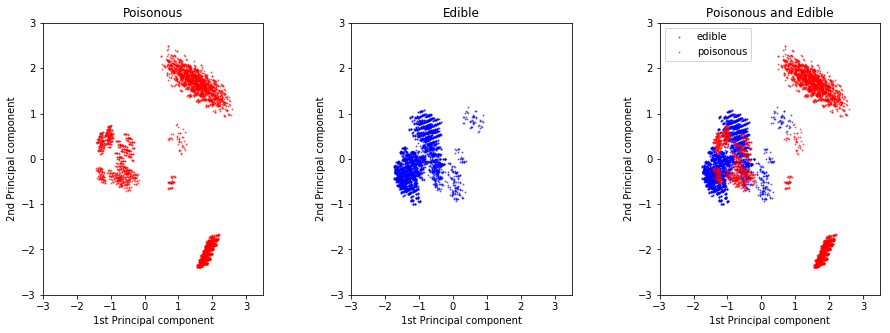

In [10]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_size_inches(15.0, 5.0)

# Note: we reverse value of first principal component for the sake of aestethics
plt.subplot(1, 3, 1)
plt.plot(df_poisonous[0]*-1, df_poisonous[1], marker='.', linestyle='', ms=2, label='poisonous', alpha=0.5, c='red')

plt.xlabel("1st Principal component")
plt.ylabel("2nd Principal component")
plt.title("Poisonous")

axes = plt.gca()
axes.set_xlim([-3,3.5])
axes.set_ylim([-3,3])
#############

plt.subplot(1, 3, 2)
plt.plot(df_edible[0]*-1, df_edible[1], marker='.', linestyle='', ms=2, label='edible', alpha=0.5, c='blue')

plt.xlabel("1st Principal component")
plt.ylabel("2nd Principal component")
plt.title("Edible")

axes = plt.gca()
axes.set_xlim([-3,3.5])
axes.set_ylim([-3,3])
#############

plt.subplot(1, 3, 3)
plt.plot(df_edible[0]*-1, df_edible[1], marker='.', linestyle='', ms=2, label='edible', alpha=0.5, c='blue')
plt.plot(df_poisonous[0]*-1, df_poisonous[1], marker='.', linestyle='', ms=2, label='poisonous', alpha=0.5, c='red')


plt.legend()

plt.xlabel("1st Principal component")
plt.ylabel("2nd Principal component")
plt.title("Poisonous and Edible")

axes = plt.gca()
axes.set_xlim([-3,3.5])
axes.set_ylim([-3,3])

del(fig, axes)

We clearly see that there are two clusters without edible mushroms and a cluster with mixed edible/poisonous mushrooms. They can be easily separated:

C:\Users\Oleksa\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


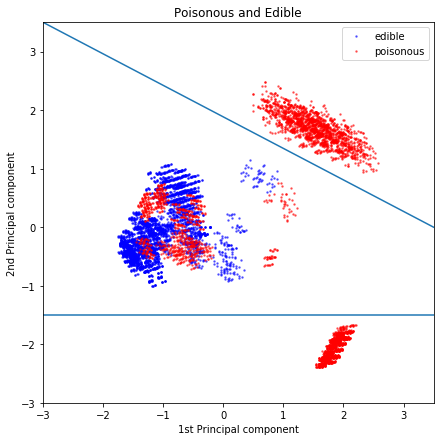

In [11]:
fig = plt.figure()
fig.set_size_inches(7.0, 7.0)

#############
plt.plot(df_edible[0]*-1, df_edible[1], marker='.', linestyle='', ms=3, label='edible', alpha=0.5, c='blue')
plt.plot(df_poisonous[0]*-1, df_poisonous[1], marker='.', linestyle='', ms=3, label='poisonous', alpha=0.5, c='red')

plt.legend()

plt.xlabel("1st Principal component")
plt.ylabel("2nd Principal component")
plt.title("Poisonous and Edible")

x = [-3, 3.5]
y = [-1.5, -1.5]
ax = fig.add_subplot(111)
line = Line2D(x, y)
ax.add_line(line)

x = [-3, 3.5]
y = [3.5, 0]
ax = fig.add_subplot(111)
line = Line2D(x, y)
ax.add_line(line)

axes = plt.gca()
axes.set_xlim([-3,3.5])
axes.set_ylim([-3,3.5])

del(axes, x, y, fig, ax, line)

37% of all mushrooms are in these two clusters  
77% of poisonous mushrooms are in these two clusters

In [14]:
# find the share of mushrooms in the lowest cluster 
a_1 = -1.5
print(round(sum(np.where(df_merged[1] < a_1, 1, 0)) / len(df_merged) * 100, 2), "%")
print(round(sum(np.where(df_merged[1] < a_1, 1, 0)) / len(df_poisonous) * 100, 2), "%")
print("#########", "\n")

# find the share of mushrooms in the upper cluster 
a_2 = 7/13
b_2 = 49/26

print(round(sum(np.where(df_merged[1] > df_merged[0]*a_2 + b_2, 1, 0)) / len(df_merged) * 100, 2), "%")
print(round(sum(np.where(df_merged[1] > df_merged[0]*a_2 + b_2, 1, 0)) / len(df_poisonous) * 100, 2), "%")
del(a_1, a_2, b_2)

15.95 %
33.09 %
######### 

21.27 %
44.13 %


Individual principal components have low explanatory power. 1st Priciple component explains 16% of variance, 32 principals components are necessary to explain 90% of variance.

32 90.54


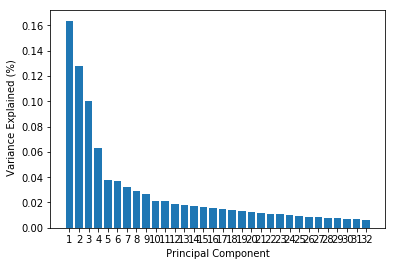

In [15]:
# claculate variance by column
vars = np.var(pcaByHandData, axis=0) / sum(np.var(pcaByHandData, axis=0))

# check how many variables we need to have 90% of variance
for n in range(len(vars)):
   var = sum(vars[:n])
   if var>=0.9:
       print(n, round(var*100,2))
       break
   
# leave only the most significant principal components
vars = vars[0:n]

plt.figure(figsize =(6 ,4))

plt.bar(range(1,len(vars)+1), vars, tick_label =range(1,len(vars)+1))
plt.xlabel (" Principal Component ")
plt.ylabel (" Variance Explained (%)")

# plt.savefig ("vars.pdf")
del(n, vars)

## Prepare data for modelling

Dataset with random stalk_root

In [16]:
# create dataframe with dummies
df_proc = pd.get_dummies(df_random, prefix_sep='.')

# remove edible from the dictionary most_frequent_level
# because we want to have edible as 1's in Y
most_frequent_level.pop("edible")

# list of colums to delete to avoide perfect multicolinearity
columns_to_delete = pd.DataFrame.from_dict(most_frequent_level, orient='index')
columns_to_delete["index"] = list(columns_to_delete.index)
columns_to_delete = list(columns_to_delete["index"] + "." + columns_to_delete[0])
columns_to_delete = ["edible.p"] + columns_to_delete

# remove most frequent levels
df_proc = df_proc.drop(columns_to_delete, axis=1)

In [17]:
# Y values
Y_random = np.array(df_proc.iloc[:,0]).reshape(df_proc.shape[0],1)

# X values
X_random = np.array(df_proc.iloc[:,1:])

# reshape data for the algorithm
Y_random = Y_random.reshape(1, Y_random.shape[0])
X_random = X_random.reshape(X_random.shape[1], X_random.shape[0])

# create test and train data
np.random.seed(15) # set a seed so that the results are consistent

# split data into train and test sets
indices = np.random.permutation(X_random.shape[1])
threshold_80 = int(X_random.shape[1]*0.8)
training_ind, test_ind = indices[:threshold_80], indices[threshold_80:]
X_rand_train, X_rand_test = X_random[:, training_ind], X_random[:, test_ind]
Y_rand_train, Y_rand_test = Y_random[:, training_ind], Y_random[:, test_ind]

del(Y_random, X_random, df_proc)

Dataset with missing stalk_root

In [18]:
# create dataframe with dummies
df_proc = pd.get_dummies(df_minus, prefix_sep='.')

# remove stalk_root it is not present in this dataset
columns_to_delete.remove('stalk_root.b')

# remove most frequent levels
df_proc = df_proc.drop(columns_to_delete, axis=1)

del(columns_to_delete)

In [19]:
# Y values
Y_minus = np.array(df_proc.iloc[:,0]).reshape(df_proc.shape[0],1)

# X values
X_minus = np.array(df_proc.iloc[:,1:])

# reshape data for the algorithm
Y_minus = Y_minus.reshape(1, Y_minus.shape[0])
X_minus = X_minus.reshape(X_minus.shape[1], X_minus.shape[0])

# create test and train data
np.random.seed(15) # set a seed so that the results are consistent

# split data into train and test sets
indices = np.random.permutation(X_minus.shape[1])
threshold_80 = int(X_minus.shape[1]*0.8)
training_ind, test_ind = indices[:threshold_80], indices[threshold_80:]
X_minus_train, X_minus_test = X_minus[:, training_ind], X_minus[:, test_ind]
Y_minus_train, Y_minus_test = Y_minus[:, training_ind], Y_minus[:, test_ind]

del(Y_minus, X_minus, df_proc)

# Run models

## Logistic regression

**First try**

In both models cost is descending slowly and stops at 800/700 iteration. Prediction power is week.

In [20]:
logist_random = logit.model(X_rand_train, Y_rand_train, X_rand_test, Y_rand_test, 
                      num_iterations=1000, learning_rate=0.5, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.687575
Cost after iteration 200: 0.686850
Cost after iteration 300: 0.686692
Cost after iteration 400: 0.686650
Cost after iteration 500: 0.686637
Cost after iteration 600: 0.686633
Cost after iteration 700: 0.686632
Cost after iteration 800: 0.686631
Cost after iteration 900: 0.686631
Train accuracy: 50.95 %
Train recall:   65.07 %
Train precicion:54.48 %
######### 

Test accuracy:  50.95 %
Test recall:    61.92 %
Test precision: 52.95 %


In [21]:
logist_minus = logit.model(X_minus_train, Y_minus_train, X_minus_test, Y_minus_test, 
                      num_iterations=1000, learning_rate=0.5, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.688307
Cost after iteration 200: 0.687697
Cost after iteration 300: 0.687574
Cost after iteration 400: 0.687544
Cost after iteration 500: 0.687536
Cost after iteration 600: 0.687534
Cost after iteration 700: 0.687533
Cost after iteration 800: 0.687533
Cost after iteration 900: 0.687533
Train accuracy: 51.32 %
Train recall:   65.45 %
Train precicion:54.51 %
######### 

Test accuracy:  51.32 %
Test recall:    61.33 %
Test precision: 53.30 %


### Try different parameters

**Learning rate**

Smallest learning rate provides >99% recall in both test and train sets. However, accuracy and precision are still small.

Thus, if mushroom is edible we almost certainly classify it as edible. However, if mushroom is poisonous there is also a high risk of classifying it as edible.

In [22]:
learning_rates = np.arange(0.005, 1.5, 0.1)

for rate in learning_rates:
    print(rate)
    logist_random = logit.model(X_rand_train, Y_rand_train, X_rand_test, Y_rand_test, 
                      num_iterations=1000, learning_rate=rate, print_cost=False)
    print("#########", "\n")

0.005
Train accuracy: 52.43 %
Train recall:   98.72 %
Train precicion:51.74 %
######### 

Test accuracy:  52.43 %
Test recall:    98.36 %
Test precision: 52.59 %
######### 

0.10500000000000001
Train accuracy: 50.52 %
Train recall:   66.59 %
Train precicion:54.39 %
######### 

Test accuracy:  50.52 %
Test recall:    62.85 %
Test precision: 52.54 %
######### 

0.20500000000000002
Train accuracy: 51.08 %
Train recall:   65.10 %
Train precicion:54.47 %
######### 

Test accuracy:  51.08 %
Test recall:    62.27 %
Test precision: 53.03 %
######### 

0.30500000000000005
Train accuracy: 51.14 %
Train recall:   65.07 %
Train precicion:54.44 %
######### 

Test accuracy:  51.14 %
Test recall:    62.03 %
Test precision: 53.10 %
######### 

0.405
Train accuracy: 51.08 %
Train recall:   65.04 %
Train precicion:54.50 %
######### 

Test accuracy:  51.08 %
Test recall:    62.03 %
Test precision: 53.05 %
######### 

0.505
Train accuracy: 50.95 %
Train recall:   65.07 %
Train precicion:54.48 %
######### 

When learning rate is very small. The model simply predicts that all mushrooms are edible. While 50% of mushrooms in the dataset are really edible, this strategy guarantees 50% accuracy and 100% recall.

Conclusion is that we need to use learning rate > 0.05. We will use learning rate equal to 0.3 - it provided the best result for both train and test accuracy.

In [24]:
logist_random = logit.model(X_rand_train, Y_rand_train, X_rand_test, Y_rand_test, 
                      num_iterations=1000, learning_rate=0.005, print_cost=False)

# what share of predictions is different from 1?
print(round(sum(logist_random['Y_prediction_train'][0]!=1) / len(logist_random['Y_prediction_train'][0]) * 100, 2), "%")

Train accuracy: 52.43 %
Train recall:   98.72 %
Train precicion:51.74 %
######### 

Test accuracy:  52.43 %
Test recall:    98.36 %
Test precision: 52.59 %
1.58 %


**Number of iterations**

Increase in the number of iterations does not improve result

In [77]:
iterations_list = np.arange(500, 2000, 500)

for element in iterations_list:
    logist_random = logit.model(X_rand_train, Y_rand_train, X_rand_test, Y_rand_test, 
                      num_iterations=element, learning_rate=0.3, print_cost=True)
    print("#########", "\n")

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.688097
Cost after iteration 200: 0.686838
Cost after iteration 300: 0.686400
Cost after iteration 400: 0.686226
Train accuracy: 54.47 %
Train recall:   69.40 %
Train precicion:54.95 %
######### 

Test accuracy:  48.18 %
Test recall:    64.04 %
Test precicion: 49.26 %
######### 

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.688097
Cost after iteration 200: 0.686838
Cost after iteration 300: 0.686400
Cost after iteration 400: 0.686226
Cost after iteration 500: 0.686151
Cost after iteration 600: 0.686115
Cost after iteration 700: 0.686098
Cost after iteration 800: 0.686089
Cost after iteration 900: 0.686085
Train accuracy: 54.33 %
Train recall:   68.57 %
Train precicion:54.90 %
######### 

Test accuracy:  48.86 %
Test recall:    63.80 %
Test precicion: 49.76 %
######### 

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.688097
Cost after iteration 200: 0.686838
Cost after iteration 300: 0.686400
Cost 

### Compare models ones more

There is no significant difference between models despite the fact that first model has by one variable more information.

In [78]:
logist_random = logit.model(X_rand_train, Y_rand_train, X_rand_test, Y_rand_test, 
                      num_iterations=1000, learning_rate=0.3, print_cost=False)
print("#########", "\n")

logist_minus = logit.model(X_minus_train, Y_minus_train, X_minus_test, Y_minus_test, 
                      num_iterations=1000, learning_rate=0.3, print_cost=False)

Train accuracy: 54.33 %
Train recall:   68.57 %
Train precicion:54.90 %
######### 

Test accuracy:  48.86 %
Test recall:    63.80 %
Test precicion: 49.76 %
######### 

Train accuracy: 54.58 %
Train recall:   67.15 %
Train precicion:55.23 %
######### 

Test accuracy:  47.20 %
Test recall:    60.65 %
Test precicion: 48.45 %


## Neural network with two layers

**First try**

Similarly to the logistic regression cost is descending slowly, predictive power is low.

In [25]:
parameters_nn = nn.nn_model(X_rand_train, Y_rand_train, 10, num_iterations = 2000, learning_rate = 0.5, print_cost=True)

print("Train set:")
result = nn.predict_nn(parameters_nn, X_rand_train, Y_rand_train)
print("#########", "\n")

print("Test set:")
result = nn.predict_nn(parameters_nn, X_rand_test,  Y_rand_test)

Cost after iteration 0: 0.693152
Cost after iteration 1000: 0.686662
Train set:
Accuracy:  54.15 %
Recall:    64.83 %
Precicion: 54.68 %
######### 

Test set:
Accuracy:  51.02 %
Recall:    61.57 %
Precicion: 53.02 %


In [22]:
parameters_nn = nn.nn_model(X_minus_train, Y_minus_train, 10, num_iterations = 2000, learning_rate = 0.5, print_cost=True)

print("Train set:")
result = nn.predict_nn(parameters_nn, X_minus_train, Y_minus_train)
print("#########", "\n")

print("Test set:")
result = nn.predict_nn(parameters_nn, X_minus_test,  Y_minus_test)

Cost after iteration 0: 0.693150
Cost after iteration 1000: 0.686019
Train set:
Accuracy:  54.72 %
Recall:    67.09 %
Precicion: 55.35 %
######### 

Test set:
Accuracy:  47.26 %
Recall:    60.41 %
Precicion: 48.49 %


array([[1, 1, 1, ..., 0, 0, 1]])

### Try different parameters

**Learning rate**

As in the case of logistic regression smallest learning rate provides the best recall rate. This is the result of predicting always one.

In [53]:
learning_rates = np.arange(0.005, 1.5, 0.1)

for rate in learning_rates:
    print(rate)
    parameters_nn = nn.nn_model(X_rand_train, Y_rand_train, 5, num_iterations = 2000, learning_rate = rate, print_cost=False)

    print("Train set:")
    pred_train = nn.predict_nn(parameters_nn, X_rand_train, Y_rand_train)
    print("####", "\n")

    print("Test set:")
    pred_test = nn.predict_nn(parameters_nn, X_rand_test,  Y_rand_test)
    print("#########", "\n")

0.005
Train set:
Accuracy:  52.04 %
Recall:    100.00 %
Precicion: 52.04 %
#### 

Test set:
Accuracy:  50.83 %
Recall:    100.00 %
Precicion: 50.83 %
######### 

0.10500000000000001
Train set:
Accuracy:  53.09 %
Recall:    97.81 %
Precicion: 52.65 %
#### 

Test set:
Accuracy:  50.77 %
Recall:    96.13 %
Precicion: 50.83 %
######### 

0.20500000000000002
Train set:
Accuracy:  54.42 %
Recall:    68.78 %
Precicion: 54.96 %
#### 

Test set:
Accuracy:  48.00 %
Recall:    63.32 %
Precicion: 49.11 %
######### 

0.30500000000000005
Train set:
Accuracy:  54.36 %
Recall:    68.51 %
Precicion: 54.93 %
#### 

Test set:
Accuracy:  48.31 %
Recall:    62.71 %
Precicion: 49.33 %
######### 

0.405
Train set:
Accuracy:  54.39 %
Recall:    68.54 %
Precicion: 54.95 %
#### 

Test set:
Accuracy:  48.31 %
Recall:    62.59 %
Precicion: 49.33 %
######### 

0.505
Train set:
Accuracy:  54.38 %
Recall:    68.54 %
Precicion: 54.94 %
#### 

Test set:
Accuracy:  48.37 %
Recall:    62.59 %
Precicion: 49.38 %
########

In [87]:
# what share of predictions is different from 1?
sum(pred_train[0]!=1) / len(pred_train[0]) * 100

Accuracy:  52.04 %
Recall:    100.00 %
Precicion: 52.04 %


0.0

**Number of iterations**

Increase in the number of iterations improves the performance on the train set, however does not affect the test set.

In [88]:
iterations_list = [500, 2000, 5000, 10000]

for element in iterations_list:
    parameters_nn = nn.nn_model(X_rand_train, Y_rand_train, 5, num_iterations = element, learning_rate = 0.3, print_cost=True)

    print("Train set:")
    result = nn.predict_nn(parameters_nn, X_rand_train, Y_rand_train)
    print("####", "\n")

    print("Test set:")
    result = nn.predict_nn(parameters_nn, X_rand_test,  Y_rand_test)
    print("#########", "\n")

Cost after iteration 0: 0.693146
Train set:
Accuracy:  52.04 %
Recall:    100.00 %
Precicion: 52.04 %
#### 

Test set:
Accuracy:  50.83 %
Recall:    100.00 %
Precicion: 50.83 %
######### 

Cost after iteration 0: 0.693146
Cost after iteration 1000: 0.686744
Train set:
Accuracy:  54.36 %
Recall:    68.51 %
Precicion: 54.93 %
#### 

Test set:
Accuracy:  48.37 %
Recall:    62.71 %
Precicion: 49.38 %
######### 

Cost after iteration 0: 0.693146
Cost after iteration 1000: 0.686744
Cost after iteration 2000: 0.686091
Cost after iteration 3000: 0.686072
Cost after iteration 4000: 0.686036
Train set:
Accuracy:  54.38 %
Recall:    68.60 %
Precicion: 54.94 %
#### 

Test set:
Accuracy:  48.25 %
Recall:    62.71 %
Precicion: 49.29 %
######### 

Cost after iteration 0: 0.693146
Cost after iteration 1000: 0.686744
Cost after iteration 2000: 0.686091
Cost after iteration 3000: 0.686072
Cost after iteration 4000: 0.686036
Cost after iteration 5000: 0.685934
Cost after iteration 6000: 0.685541
Cost aft

In [89]:
# what if we will run through 20000 iterations?
parameters_nn = nn.nn_model(X_rand_train, Y_rand_train, 5, num_iterations = 20000, learning_rate = 0.3, print_cost=True)

print("Train set:")
result = nn.predict_nn(parameters_nn, X_rand_train, Y_rand_train)
print("####", "\n")

print("Test set:")
result = nn.predict_nn(parameters_nn, X_rand_test,  Y_rand_test)
print("#########", "\n")

Cost after iteration 0: 0.693146
Cost after iteration 1000: 0.686744
Cost after iteration 2000: 0.686091
Cost after iteration 3000: 0.686072
Cost after iteration 4000: 0.686036
Cost after iteration 5000: 0.685934
Cost after iteration 6000: 0.685541
Cost after iteration 7000: 0.683823
Cost after iteration 8000: 0.677108
Cost after iteration 9000: 0.663877
Cost after iteration 10000: 0.652974
Cost after iteration 11000: 0.638400
Cost after iteration 12000: 0.626902
Cost after iteration 13000: 0.621900
Cost after iteration 14000: 0.618500
Cost after iteration 15000: 0.615829
Cost after iteration 16000: 0.613579
Cost after iteration 17000: 0.611454
Cost after iteration 18000: 0.609397
Cost after iteration 19000: 0.607385
Train set:
Accuracy:  67.16 %
Recall:    72.03 %
Precicion: 67.22 %
#### 

Test set:
Accuracy:  48.18 %
Recall:    54.96 %
Precicion: 49.13 %
######### 



**Number of nodes in the inner layer**

Increase in the number of nodes slightly decreases spead of the gradient descent. There is a minor increase in accuracy and decrease in recall.

In [222]:
nodes_list = [2, 5, 10]
nodes_list = [10]

for element in nodes_list:
    print(str(element), "nodes")
    parameters_nn = nn.nn_model(X_rand_train, Y_rand_train, element, num_iterations = 10000, learning_rate = 0.3, print_cost=True)

    print("Train set:")
    result = nn.predict_nn(parameters_nn, X_rand_train, Y_rand_train)
    print("####", "\n")

    print("Test set:")
    result = nn.predict_nn(parameters_nn, X_rand_test,  Y_rand_test)
    print("#########", "\n")

10 nodes
Cost after iteration 0: 0.693151
Cost after iteration 1000: 0.687191
Cost after iteration 2000: 0.686646
Cost after iteration 3000: 0.686587
Cost after iteration 4000: 0.686294
Cost after iteration 5000: 0.684863
Cost after iteration 6000: 0.680601
Cost after iteration 7000: 0.672698
Cost after iteration 8000: 0.663080
Cost after iteration 9000: 0.654794
Train set:
Accuracy:  61.87 %
Recall:    65.24 %
Precicion: 62.49 %
#### 

Test set:
Accuracy:  50.46 %
Recall:    54.67 %
Precicion: 52.88 %
######### 



## Intermezzo. Whats went wrong?

Lets try to visualise which points are wrongly classified

In [223]:
# save the model output
pred_train =  nn.predict_nn(parameters_nn, X_rand_train, Y_rand_train)
pred_test =  nn.predict_nn(parameters_nn, X_rand_test,  Y_rand_test)

# merge results and indices
pred_train = pd.DataFrame.from_records(pred_train.T)
pred_train['index'] = list(training_ind)
pred_train['y']     = list(Y_rand_train[0])
pred_test = pd.DataFrame.from_records(pred_test.T)
pred_test['index'] = list(test_ind)
pred_test['y']    = list(Y_rand_test[0])

df_pred = pd.concat([pred_train, pred_test]) 
df_pred = df_pred.sort_values(by=['index'])
df_pred = df_pred.reset_index(drop=True) # reset row names

df_pred['wrong'] = df_pred[0] != df_pred['y']
df_pred['wrong'] += 0

Accuracy:  61.87 %
Recall:    65.24 %
Precicion: 62.49 %
Accuracy:  50.46 %
Recall:    54.67 %
Precicion: 52.88 %


Draw graph

C:\Users\Oleksa\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


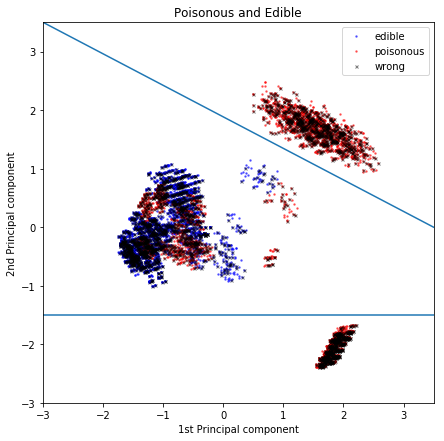

In [231]:
df_graph= df_merged[df_pred['wrong']==1]

fig = plt.figure()
fig.set_size_inches(7.0, 7.0)

#############
plt.plot(df_edible[0]*-1, df_edible[1], marker='.', linestyle='', ms=3, label='edible', alpha=0.5, c='blue')
plt.plot(df_poisonous[0]*-1, df_poisonous[1], marker='.', linestyle='', ms=3, label='poisonous', alpha=0.5, c='red')
plt.plot(df_graph[0]*-1, df_graph[1], marker='x', linestyle='', ms=3, label='wrong', alpha=0.5, c='black')

plt.legend()

plt.xlabel("1st Principal component")
plt.ylabel("2nd Principal component")
plt.title("Poisonous and Edible")

x = [-3, 3.5]
y = [-1.5, -1.5]
ax = fig.add_subplot(111)
line = Line2D(x, y)
ax.add_line(line)

x = [-3, 3.5]
y = [3.5, 0]
ax = fig.add_subplot(111)
line = Line2D(x, y)
ax.add_line(line)

axes = plt.gca()
axes.set_xlim([-3,3.5])
axes.set_ylim([-3,3.5])

del(axes, x, y, fig, ax, line)

Model was not able to find upper and lower clusters. Mistakes are present in all three clusters.

### What if we will run through 1,000,000 iterations?

After million itarations accuracy on the train set is 83%, but performance on test set is not improved.

In [245]:
parameters_nn = nn.nn_model(X_rand_train, Y_rand_train, 10, num_iterations = 1000000, learning_rate = 0.3, print_cost=True)

print("Train set:")
result = nn.predict_nn(parameters_nn, X_rand_train, Y_rand_train)
print("####", "\n")

print("Test set:")
result = nn.predict_nn(parameters_nn, X_rand_test,  Y_rand_test)
print("#########", "\n")

Cost after iteration 0: 0.693151
Cost after iteration 1000: 0.687191
Cost after iteration 2000: 0.686646
Cost after iteration 3000: 0.686587
Cost after iteration 4000: 0.686294
Cost after iteration 5000: 0.684863
Cost after iteration 6000: 0.680601
Cost after iteration 7000: 0.672698
Cost after iteration 8000: 0.663080
Cost after iteration 9000: 0.654794
Cost after iteration 10000: 0.644120
Cost after iteration 11000: 0.628517
Cost after iteration 12000: 0.612626
Cost after iteration 13000: 0.598460
Cost after iteration 14000: 0.583324
Cost after iteration 15000: 0.570555
Cost after iteration 16000: 0.561151
Cost after iteration 17000: 0.551679
Cost after iteration 18000: 0.540271
Cost after iteration 19000: 0.529017
Cost after iteration 20000: 0.519096
Cost after iteration 21000: 0.510703
Cost after iteration 22000: 0.504937
Cost after iteration 23000: 0.500911
Cost after iteration 24000: 0.497440
Cost after iteration 25000: 0.494483
Cost after iteration 26000: 0.492022
Cost after ite

Cost after iteration 219000: 0.391392
Cost after iteration 220000: 0.391218
Cost after iteration 221000: 0.391045
Cost after iteration 222000: 0.390874
Cost after iteration 223000: 0.390703
Cost after iteration 224000: 0.390533
Cost after iteration 225000: 0.390365
Cost after iteration 226000: 0.390197
Cost after iteration 227000: 0.390031
Cost after iteration 228000: 0.389865
Cost after iteration 229000: 0.389701
Cost after iteration 230000: 0.389537
Cost after iteration 231000: 0.389374
Cost after iteration 232000: 0.389212
Cost after iteration 233000: 0.389051
Cost after iteration 234000: 0.388891
Cost after iteration 235000: 0.388732
Cost after iteration 236000: 0.388573
Cost after iteration 237000: 0.388416
Cost after iteration 238000: 0.388259
Cost after iteration 239000: 0.388102
Cost after iteration 240000: 0.387947
Cost after iteration 241000: 0.387792
Cost after iteration 242000: 0.387638
Cost after iteration 243000: 0.387484
Cost after iteration 244000: 0.387331
Cost after i

Cost after iteration 435000: 0.366626
Cost after iteration 436000: 0.366553
Cost after iteration 437000: 0.366479
Cost after iteration 438000: 0.366406
Cost after iteration 439000: 0.366333
Cost after iteration 440000: 0.366260
Cost after iteration 441000: 0.366187
Cost after iteration 442000: 0.366115
Cost after iteration 443000: 0.366043
Cost after iteration 444000: 0.365972
Cost after iteration 445000: 0.365900
Cost after iteration 446000: 0.365829
Cost after iteration 447000: 0.365758
Cost after iteration 448000: 0.365688
Cost after iteration 449000: 0.365617
Cost after iteration 450000: 0.365547
Cost after iteration 451000: 0.365478
Cost after iteration 452000: 0.365408
Cost after iteration 453000: 0.365339
Cost after iteration 454000: 0.365270
Cost after iteration 455000: 0.365201
Cost after iteration 456000: 0.365133
Cost after iteration 457000: 0.365064
Cost after iteration 458000: 0.364996
Cost after iteration 459000: 0.364929
Cost after iteration 460000: 0.364861
Cost after i

Cost after iteration 651000: 0.354319
Cost after iteration 652000: 0.354274
Cost after iteration 653000: 0.354229
Cost after iteration 654000: 0.354184
Cost after iteration 655000: 0.354139
Cost after iteration 656000: 0.354095
Cost after iteration 657000: 0.354050
Cost after iteration 658000: 0.354006
Cost after iteration 659000: 0.353962
Cost after iteration 660000: 0.353918
Cost after iteration 661000: 0.353874
Cost after iteration 662000: 0.353830
Cost after iteration 663000: 0.353786
Cost after iteration 664000: 0.353743
Cost after iteration 665000: 0.353700
Cost after iteration 666000: 0.353656
Cost after iteration 667000: 0.353613
Cost after iteration 668000: 0.353570
Cost after iteration 669000: 0.353527
Cost after iteration 670000: 0.353484
Cost after iteration 671000: 0.353441
Cost after iteration 672000: 0.353399
Cost after iteration 673000: 0.353356
Cost after iteration 674000: 0.353313
Cost after iteration 675000: 0.353271
Cost after iteration 676000: 0.353228
Cost after i

Cost after iteration 867000: 0.346204
Cost after iteration 868000: 0.346174
Cost after iteration 869000: 0.346145
Cost after iteration 870000: 0.346115
Cost after iteration 871000: 0.346085
Cost after iteration 872000: 0.346056
Cost after iteration 873000: 0.346026
Cost after iteration 874000: 0.345997
Cost after iteration 875000: 0.345967
Cost after iteration 876000: 0.345938
Cost after iteration 877000: 0.345908
Cost after iteration 878000: 0.345879
Cost after iteration 879000: 0.345849
Cost after iteration 880000: 0.345820
Cost after iteration 881000: 0.345790
Cost after iteration 882000: 0.345761
Cost after iteration 883000: 0.345732
Cost after iteration 884000: 0.345702
Cost after iteration 885000: 0.345673
Cost after iteration 886000: 0.345643
Cost after iteration 887000: 0.345614
Cost after iteration 888000: 0.345585
Cost after iteration 889000: 0.345555
Cost after iteration 890000: 0.345526
Cost after iteration 891000: 0.345497
Cost after iteration 892000: 0.345467
Cost after i

#### Visualise results

Visually results are better especially in the upper cluster

In [259]:
parameters_million = parameters_nn

# save the model output
pred_train =  nn.predict_nn(parameters_million, X_rand_train, Y_rand_train)
pred_test =  nn.predict_nn(parameters_nn, X_rand_test,  Y_rand_test)

# merge results and indices
pred_train = pd.DataFrame.from_records(pred_train.T)
pred_train['index'] = list(training_ind)
pred_train['y']     = list(Y_rand_train[0])
pred_test = pd.DataFrame.from_records(pred_test.T)
pred_test['index'] = list(test_ind)
pred_test['y']    = list(Y_rand_test[0])

df_pred = pd.concat([pred_train, pred_test]) 
df_pred = df_pred.sort_values(by=['index'])
df_pred = df_pred.reset_index(drop=True) # reset row names

df_pred['wrong'] = df_pred[0] != df_pred['y']
df_pred['wrong'] += 0

Accuracy:  82.75 %
Recall:    77.71 %
Precicion: 87.45 %
Accuracy:  52.43 %
Recall:    48.60 %
Precicion: 55.54 %


C:\Users\Oleksa\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


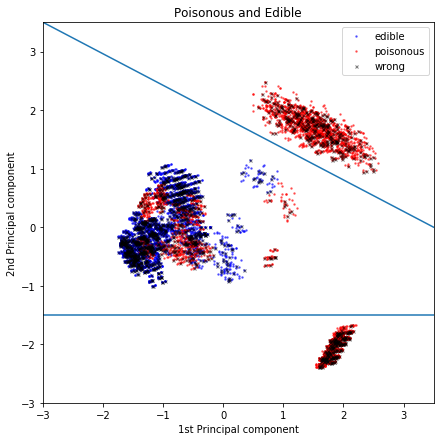

In [261]:
df_graph= df_merged[df_pred['wrong']==1]

fig = plt.figure()
fig.set_size_inches(7.0, 7.0)

#############
plt.plot(df_edible[0]*-1, df_edible[1], marker='.', linestyle='', ms=3, label='edible', alpha=0.5, c='blue')
plt.plot(df_poisonous[0]*-1, df_poisonous[1], marker='.', linestyle='', ms=3, label='poisonous', alpha=0.5, c='red')
plt.plot(df_graph[0]*-1, df_graph[1], marker='x', linestyle='', ms=3, label='wrong', alpha=0.5, c='black')

plt.legend()

plt.xlabel("1st Principal component")
plt.ylabel("2nd Principal component")
plt.title("Poisonous and Edible")

x = [-3, 3.5]
y = [-1.5, -1.5]
ax = fig.add_subplot(111)
line = Line2D(x, y)
ax.add_line(line)

x = [-3, 3.5]
y = [3.5, 0]
ax = fig.add_subplot(111)
line = Line2D(x, y)
ax.add_line(line)

axes = plt.gca()
axes.set_xlim([-3,3.5])
axes.set_ylim([-3,3.5])

plt.savefig ("million_nn.pdf")
del(axes, x, y, fig, ax, line)

The rate at which model improves significantly slows down after approximately 40,000 iterations

![Graph_cost_evolution](img/nn_cost_function.png)

## Decision tree

Our data consists of many categorical variables. Decision trees are well-suited for classyfying such data.

Results are very good. Both train and test datasets have accuracy, recall and precision above 95%. Results can be even better but increase in the number of nodes has risk of overfitting. 95% is more than enough:)

### Prepare dataset

In [26]:
# create dataframe with dummies
df_proc = pd.get_dummies(df_random, prefix_sep='.')

# list of colums to delete to avoide perfect multicolinearity
columns_to_delete = pd.DataFrame.from_dict(most_frequent_level, orient='index')
columns_to_delete["index"] = list(columns_to_delete.index)
columns_to_delete = list(columns_to_delete["index"] + "." + columns_to_delete[0])
columns_to_delete = ["edible.p"] + columns_to_delete

# remove most frequent levels
df_proc = df_proc.drop(columns_to_delete, axis=1)

In [28]:
# transform data to numpy array
random = np.array(df_proc)

# create test and train data
np.random.seed(15) # set a seed so that the results are consistent

indices = np.random.permutation(df_proc.shape[0])
threshold_80 = int(df_proc.shape[0]*0.8)
training_ind, test_ind = indices[:threshold_80], indices[threshold_80:]\

rand_train, rand_test = random[training_ind, :], random[test_ind, :]

### Run algorithm

In [29]:
Rand_tree = dt.DecisionTree(rand_train)

In [30]:
tree_rules = Rand_tree.partition(0.9)

Tree node: c
Level: 0
Number of elements: 6499
Majority class: 1
Accuracy: 0.5158


Gini: 0.30816817006285485
Partition column: 21
Partition midpoint: 0.5
####### 
 

Tree node: cl
Level: 1
Number of elements: 4780
Majority class: 1
Accuracy: 0.7013


Gini: 0.1164196853609874
Partition column: 29
Partition midpoint: 0.5
####### 
 

Tree node: cll
Level: 2
Number of elements: 3215
Majority class: 1
Accuracy: 0.9726
Terminal node!
####### 
 

Tree node: clr
Level: 2
Number of elements: 1565
Majority class: 0
Accuracy: 0.8562


Gini: 0.18123243706428258
Partition column: 6
Partition midpoint: 0.5
####### 
 

Tree node: clrl
Level: 3
Number of elements: 1344
Majority class: 0
Accuracy: 0.9293
Terminal node!
####### 
 

Tree node: clrr
Level: 3
Number of elements: 221
Majority class: 1
Accuracy: 0.5882


Gini: 0.10695187165775408
Partition column: 20
Partition midpoint: 0.5
####### 
 

Tree node: clrrl
Level: 4
Number of elements: 143
Majority class: 1
Accuracy: 0.9091
Terminal node!
######

### Evaluate results

Train dataset

In [32]:
result = dt.print_tree_metrics(tree_rules)

Accuracy: 96.98 %
Recall: 96.99 %
Precision: 97.17 %


Test dataset

In [33]:
test_labels = dt.lable_using_tree(rand_test, tree_rules)

In [34]:
result = dt.eval_tree_test(rand_test, test_labels)

Accuracy: 97.05 %
Recall: 97.31 %
Precision: 97.08 %
